# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import warnings
import math
import os
import random
import dill

# Helper Methods

In [2]:
def generate_random_sample(X, size):
    '''
    Given a list X, 
    generate random samples of given size
    '''
    Z_temp = random.sample(list(X), size)
    
    #Concatenation
    Z = [Z_temp[0]]
    for val in Z_temp[1:]:
        Z = np.concatenate([Z,[val]])
    
    return Z

def convert_values_to_list(list_val):
    '''
    Given a list X = [1 2 3] , 
    return X = [[1],[2],[3]]
    '''
    X = []
    for i in list_val:
        X.append([i])
    return X

def conversion_list_of_list(X, DIMENSION):
    '''
    Given a list X with values in lists,
    X = [[ 3  2  2],[4 8 10]]
    Convert each value to a list
    Return list of lists, array of lengths of each sequence
    X = [[3] [2] [2] [4] [8] [10]]
    ''' 
    X_new = []
    length = len(X)
    for idx, val_list in enumerate(X):
        Y = []
        for val in val_list:
            Y.append([val])
        X_new.append(Y)

    #Concatenation
    Z = X_new[0]
    for val_list in X_new[1:]:
        Z = np.concatenate([Z,val_list])

    # assign array of lengths for HMM
    lengths = [DIMENSION]*length
    
    return Z,lengths

#Calculate likelihood for given sequence according to given HMMs and return HMM
def likelihood_sequence(sequence, HMM_array):
    '''
    Given list of K HMMs and sequence,
    determines likelihood of sequence under all HMM models
    Returns index of HMM which has max likelihood
    ''' 
    scores = []
    length = [len(sequence)]
    for i, HMM in enumerate(HMM_array):
        calculated_score = HMM.score(sequence, length)
        scores.append(calculated_score)
    idx = scores.index(max(scores))
    return idx

def HMM_model_stats(model):
    '''
    Details of HMM model
    ''' 
    print("*************************************")
    print("Transition matrix")
    print(model.transmat_)
    print("*************************************")
    print("Means and stds of each hidden state")
    for i in range(model.n_components):
        print("Hidden state {0}".format(i))
        print("mean = ", model.means_[i])
        print("std = ", [np.sqrt(model.covars_[i])])
        print()

def BIC(model,X,lengths):
    LogLikelihood = model.score(X,lengths)
    num_hidden_states = model.n_components
    # D counts transition matrix (emission estimated by PDF), means = num_hidden_states  
    # covariance matrix = num_hidden_states
    D = num_hidden_states**2-num_hidden_states + 2*num_hidden_states
    BIC = LogLikelihood - (D/2)*np.log(len(X))
    return BIC
    
def BIC_array(HMM_array,X_i):
    BIC_total = 0
    for i in range(len(X_i)):
        model = HMM_array[i]
        X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        BIC_total+= BIC(model,X,lengths)
    return BIC_total

def likelihood_array(HMM_array,X_i):
    likelihood_total = 0
    for i in range(len(X_i)):
        if(len(X_i[i])>=HMM_array[i].n_components):
            model = HMM_array[i]
            X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
            LogLikelihood = model.score(X,lengths)
            likelihood = LogLikelihood 
            likelihood_total+= likelihood
    return likelihood_total

def plot_BIC(list_k, BIC_score):
    fig = plt.subplot(111)
    plt.plot(list_k, BIC_score, marker='o')  
    plt.xlabel('Value of K')
    plt.ylabel('Objective')
    plt.title('BIC')
    plt.show() 

def print_stats(assignments,length):
    for i in range(length):
        if(i%100==0):
            print(assignments[i])   

# Load Data and Clean

In [4]:
#Dataset
df_rpf = pd.read_csv('RPKMOutput/RPF.txt',sep=' ')
df_rpf = df_rpf[(df_rpf['cdReads0'] >= 10) & (df_rpf['cdReads1'] >= 10) & (df_rpf['cdReads2'] >= 10)& (df_rpf['cdReads3'] >= 10)& (df_rpf['cdReads4'] >= 10)]
df_main = df_rpf[['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']]
LENGTH,DIMENSION = df_main.shape
print("Dataset size is",LENGTH)
print("Features are", DIMENSION)
print(df_main.head(5))
X = np.log2(df_main.values)
print("****************************")
print("First 5 log2 values\n",X[:5])

Dataset size is 9143
Features are 5
     cdRPKM0    cdRPKM1    cdRPKM2    cdRPKM3    cdRPKM4
0  16.487335  13.206484  15.968568  16.540714  20.464235
2  30.248942  37.241851  48.740039  43.317961  28.738355
3  47.210965  44.043594  49.195554  61.069347  64.149959
4   6.532635   5.915217   7.135519   6.207228   7.285780
5  50.945586  41.271537  51.791424  54.501149  37.697275
****************************
First 5 log2 values
 [[ 4.04328633  3.72317452  3.99716301  4.04794959  4.35503285]
 [ 4.91881276  5.21885288  5.60703552  5.43689341  4.84490558]
 [ 5.56105006  5.46086031  5.62045603  5.93237652  6.00337643]
 [ 2.70766509  2.56443105  2.83501828  2.63394906  2.86508346]
 [ 5.67088524  5.36707525  5.69464132  5.76821475  5.23638835]]


# Arrays with HMM models for 1<=K<=25

In [5]:
HMM_K_ARRAYS = []
X_i_K_ARRAYS = []

# Check likelihood and do assignments

In [6]:
K_values = [12]

In [ ]:
for K in K_values:
    HMM_array = []
    X_i = []
    print("**************** K =", K ,"************************")
    for i in range(K):
        X_i.append([])
        
    NUM_ITERATIONS = 0
    NUM_CLUSTER_PREV = {}
    NUM_CLUSTER_NOW = {}
    
    # Sequences for initial HMM estimation
    # Make K subsets data of LENGTH
    for i in range(LENGTH):
        for j in range(K):
            if(i%K==j):
                X_i[j].append(list(X[i]))
                NUM_CLUSTER_PREV[i] = j
                
    for i in range(K):
        model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
        X_temp, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        model.fit(X_temp, lengths)
        HMM_array.append(model)
    
    likelihood_prev = likelihood_array(HMM_array,X_i)
    print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_prev)
    NUM_ITERATIONS+=1
    while (True):
        # Assign all sequences to HMM models

        print("************ Check likelihood of sequence in HMM  *********")
        NUM_CLUSTER_NOW = {}
        for idx,x in enumerate(X):
            sequence = convert_values_to_list(x)
            hmm_index = likelihood_sequence(sequence, HMM_array)
            X_i[hmm_index].append(list(x))
            NUM_CLUSTER_NOW[idx] = hmm_index
        print("************ Checking likelihood done  *********")

        # Re-estimate parameters for new HMMs
        print("************ Re-estimating HMM *********")
        HMM_array_prev = HMM_array
        HMM_array = []
        for i in range(K):
            model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
            if(len(X_i[i])>=model.n_components):
                X_temp, lengths = conversion_list_of_list(X_i[i], DIMENSION)
                model.fit(X_temp, lengths)
                HMM_array.append(model)
            else:
                HMM_array.append(HMM_array_prev[i])
        print("************ Re-estimation done *********")
        likelihood_curr = likelihood_array(HMM_array,X_i)
        print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_curr)
        print("*****************************************")

        # if no reassignments, then break
        if ((NUM_CLUSTER_PREV == NUM_CLUSTER_NOW) or NUM_ITERATIONS>100):
            HMM_K_ARRAYS.append(HMM_array)
            X_i_K_ARRAYS.append(X_i)
            break
        else:
            # initialize empty subsets of data for next iteration
            X_i = []
            for i in range(K):
                X_i.append([])

            NUM_CLUSTER_PREV = NUM_CLUSTER_NOW
            print("Num iterations is:", NUM_ITERATIONS)
            NUM_ITERATIONS += 1
            likelihood_prev = likelihood_curr
    print("**********************************************************\n\n")

In [13]:
print(len(HMM_K_ARRAYS))
print(len(X_i_K_ARRAYS))

1
1


In [14]:
import seaborn as sns

def plot_cluster(X,count):
    fig = plt.subplot(111)
    axes = plt.gca()
    axes.set_ylim([0,15])
    var_plot_list = ['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']
    total=0
    for i in range(len(X)):
        fig.plot(var_plot_list, X[i])
        total+=1
    title = "HMM "+ str(count)+" : " + str(total) + " points "
    plt.title(title)
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/5points/RPF/Clusters/Cluster'+str(count)+'.png')
    plt.show()
    
def plot_heatmap(X,idx):
    plt.figure()
    sns.heatmap(X,vmin=0, vmax=10)
    plt.title('Heatmap'+str(idx))
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/5points/RPF/Heat Map/HeatMap'+str(idx+1)+'.png')
    plt.show()

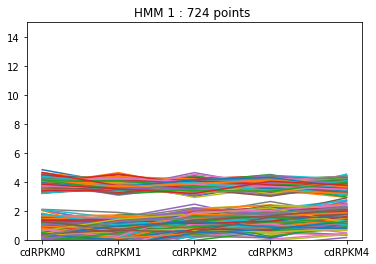

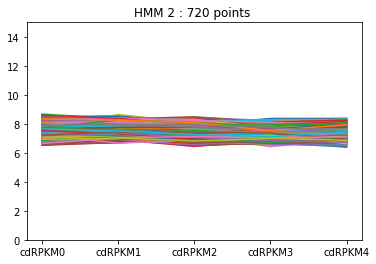

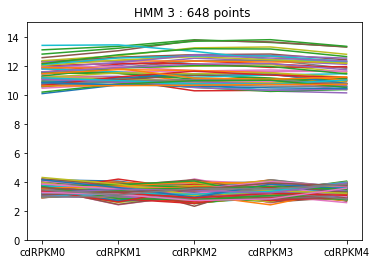

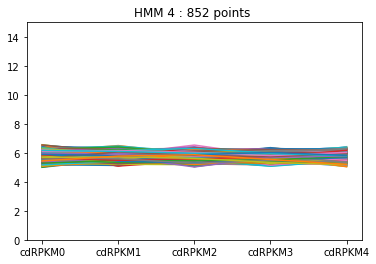

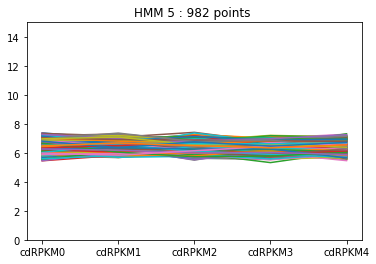

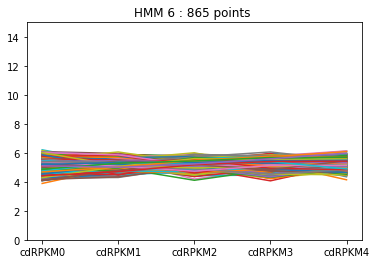

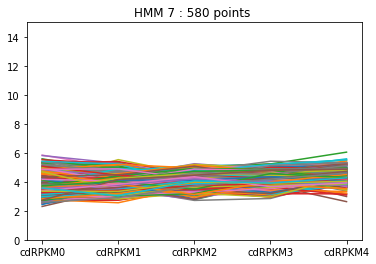

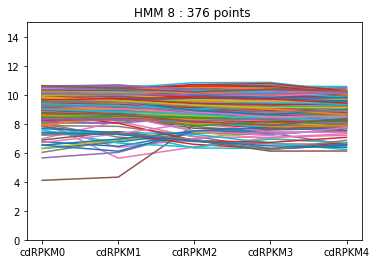

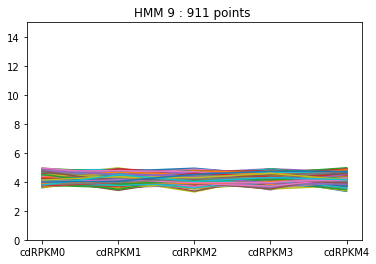

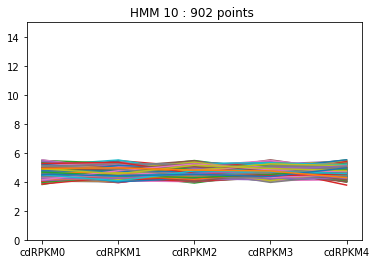

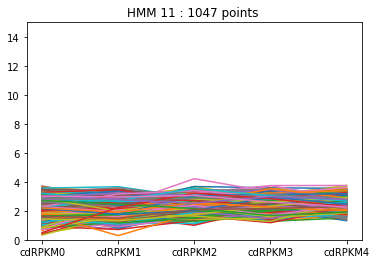

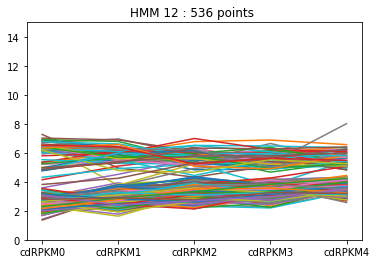

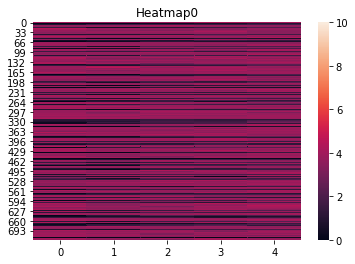

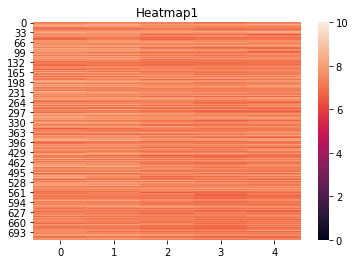

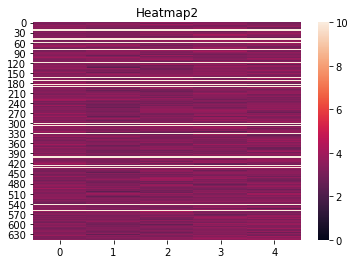

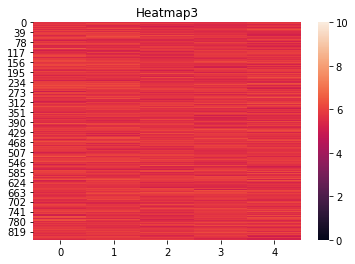

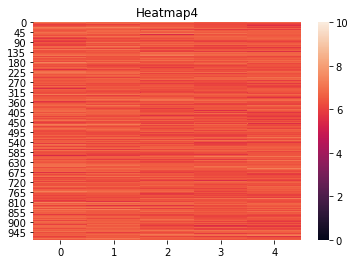

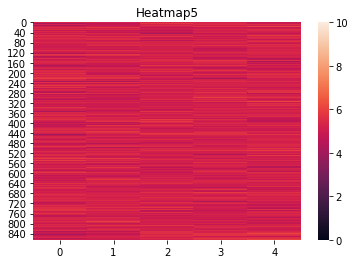

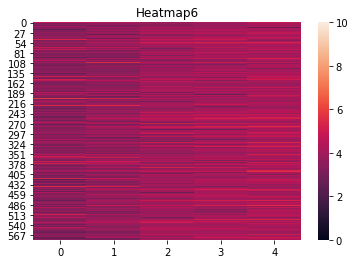

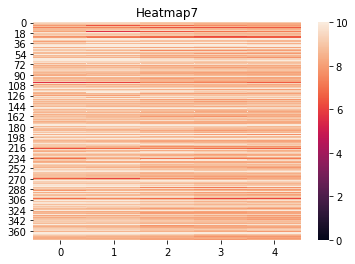

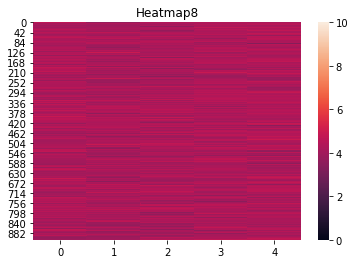

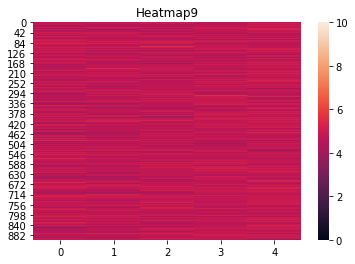

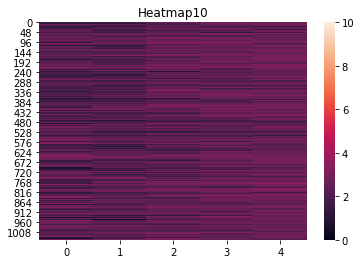

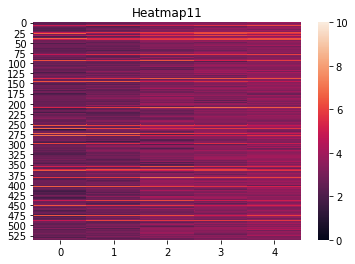

In [15]:
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_cluster(X,idx+1)
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_heatmap(X,idx)

In [16]:
df = pd.read_csv('RPKMOutput/RPF.txt',sep=' ')
df = df[(df['cdReads0'] >= 10) & (df['cdReads1'] >= 10) & (df['cdReads2'] >= 10)& (df['cdReads3'] >= 10)& (df['cdReads4'] >= 10)]
df = df.dropna()
df = df[['AccNum','GeneName','cdReads0','cdReads1','cdReads2','cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']]
df[['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']] = df[['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']].transform(lambda x: np.log2(x))
df.head(5)

,AccNum,GeneName,cdReads0,cdReads1,cdReads2,cdRPKM0,cdRPKM1,cdRPKM2,cdRPKM3,cdRPKM4
0,NM_017847,ODR4,93.0,62.0,49.0,4.043286,3.723175,3.997163,4.047950,4.355033
2,NM_001003803,ATP5S,81.0,83.0,71.0,4.918813,5.218853,5.607036,5.436893,4.844906
3,NM_001003800,BICD2,501.0,389.0,284.0,5.561050,5.460860,5.620456,5.932377,6.003376
4,NM_016649,ESF1,69.0,52.0,41.0,2.707665,2.564431,2.835018,2.633949,2.865083
5,NM_016647,THEM6,132.0,89.0,73.0,5.670885,5.367075,5.694641,5.768215,5.236388


In [17]:
for idx,x in enumerate(X_i_K_ARRAYS[0]):
    genes=[]
    acc_nums=[]
    for row in x:
        temp = (df.loc[(df['cdRPKM0'] == row[0])& (df['cdRPKM1']== row[1]) & (df['cdRPKM2']== row[2])])
        if(not temp.empty):
            genes.append(temp['GeneName'].values[0])
            acc_nums.append(temp['AccNum'].values[0])
    print(len(x),len(genes))
    with open('/Users/akankshitadash/Desktop/Gene Ontology/5points/RPF/Gene Names/Gene'+str(idx+1)+'.txt','w') as f:
        for gene in genes:
            f.write("%s\n" % gene)
    with open('/Users/akankshitadash/Desktop/Gene Ontology/5points/RPF/Gene Names/AccNum'+str(idx+1)+'.txt','w') as f:
        for acc_num in acc_nums:
            f.write("%s\n" % acc_num)

724 724
720 720
648 648
852 852
982 982
865 865
580 580
376 376
911 911
902 902
1047 1047
536 536


In [ ]:
dill.dump_session('HMM_GaussianHMM_5points_RPF.db')